# **Hackday 2° Edicao - Classificação**

# 0.0. IMPORTS

In [1]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import requests
import warnings
import inflection
import seaborn as sns
import xgboost as xgb

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML

from sklearn.metrics       import mean_absolute_error, mean_squared_error, f1_score
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
import sklearn.model_selection as ms
from xgboost import XGBClassifier

warnings.filterwarnings( 'ignore' )

## 0.1. Helper Functions

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', '{:.2f}'.format)
    
    sns.set()

In [3]:
jupyter_settings()

## 0.2. Loading data

In [4]:
df_train_raw = pd.read_csv( 'data/train.csv' )
df_test_raw = pd.read_csv('data/test.csv')

# 1.0. DESCRICAO DOS DADOS

In [5]:
df1 = df_train_raw.copy()

In [6]:
df1.head()

,id_cliente,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,pessoa_polit_exp,limite_adicional
0,1767,21,278.17,2577.05,24196.90,104.31,31.04,6,5,7,21,14,9,15,Não,Não,Negar
1,11920,40,268.87,2465.39,19227.38,69.86,36.92,5,8,5,40,23,10,18,Não,Não,Negar
2,8910,36,446.64,1055.29,42822.28,134.20,34.56,0,3,6,26,13,3,15,Sim,Não,Negar
3,4964,58,321.14,703.05,51786.83,297.35,31.49,0,3,7,12,7,2,1,Sim,Não,Negar
4,10100,35,428.72,891.29,44626.85,134.20,28.03,2,8,7,24,10,8,20,Sim,Não,Negar


## 1.1. Rename Columns

In [7]:
# cols_old = df1.columns.values

# snakecase = lambda x: inflection.underscore( x )

# cols_new = list( map( snakecase, cols_old ) )

# # rename
# df1.columns = cols_new

## 1.2. Data Dimensions

In [8]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 9500
Number of Cols: 17


## 1.3. Data Types

In [9]:
df1.dtypes

id_cliente                   int64
idade                        int64
saldo_atual                float64
divida_atual               float64
renda_anual                float64
valor_em_investimentos     float64
taxa_utilizacao_credito    float64
num_emprestimos              int64
num_contas_bancarias         int64
num_cartoes_credito          int64
dias_atraso_dt_venc          int64
num_pgtos_atrasados          int64
num_consultas_credito        int64
taxa_juros                   int64
investe_exterior            object
pessoa_polit_exp            object
limite_adicional            object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

id_cliente                 0
idade                      0
saldo_atual                0
divida_atual               0
renda_anual                0
valor_em_investimentos     0
taxa_utilizacao_credito    0
num_emprestimos            0
num_contas_bancarias       0
num_cartoes_credito        0
dias_atraso_dt_venc        0
num_pgtos_atrasados        0
num_consultas_credito      0
taxa_juros                 0
investe_exterior           0
pessoa_polit_exp           0
limite_adicional           0
dtype: int64

## 1.5. Fillout NA

## 1.6. Change Data Types

In [11]:
df1.dtypes

id_cliente                   int64
idade                        int64
saldo_atual                float64
divida_atual               float64
renda_anual                float64
valor_em_investimentos     float64
taxa_utilizacao_credito    float64
num_emprestimos              int64
num_contas_bancarias         int64
num_cartoes_credito          int64
dias_atraso_dt_venc          int64
num_pgtos_atrasados          int64
num_consultas_credito        int64
taxa_juros                   int64
investe_exterior            object
pessoa_polit_exp            object
limite_adicional            object
dtype: object

## 1.7. Descriptive Statistics

In [12]:
num_attributes, cat_attributes = df1.select_dtypes( include=['int64', 'float64'] ), df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Atributes

In [13]:
desc_stats = pd.concat([num_attributes.describe(), pd.DataFrame([num_attributes.skew(), num_attributes.kurtosis()], index=['skew', 'kurtosis'])], axis=0).T
desc_stats

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
id_cliente,9500.00,6210.53,3603.24,1.00,3091.75,6172.50,9320.25,12500.00,0.01,-1.20
idade,9500.00,126.40,685.04,18.00,28.00,38.00,47.00,8598.00,9.09,87.61
saldo_atual,9500.00,404.53,217.70,0.09,272.36,337.17,471.26,1602.04,1.62,3.10
divida_atual,9500.00,1437.09,1156.26,0.23,573.62,1175.73,1963.33,4998.07,1.19,0.85
renda_anual,9500.00,195037.27,1454273.73,10473.87,26207.90,45991.11,80449.83,23279657.98,11.87,149.39
valor_em_investimentos,9500.00,612.00,2002.44,0.00,76.08,134.20,249.18,10000.00,4.44,17.87
taxa_utilizacao_credito,9500.00,32.27,5.11,20.99,28.08,32.26,36.46,49.56,0.04,-0.92
num_emprestimos,9500.00,10.86,62.56,0.00,2.00,3.00,6.00,1496.00,16.37,310.98
num_contas_bancarias,9500.00,17.55,120.98,0.00,3.00,6.00,7.00,1779.00,10.88,123.22
num_cartoes_credito,9500.00,21.43,122.68,1.00,4.00,6.00,7.00,1479.00,8.56,76.79


### 1.7.2. Categorical Atributes

In [14]:
cat_attributes.apply( lambda x: x.nunique() )

investe_exterior    2
pessoa_polit_exp    2
limite_adicional    2
dtype: int64

Criar boxplots para cada variável categórica X variável target.

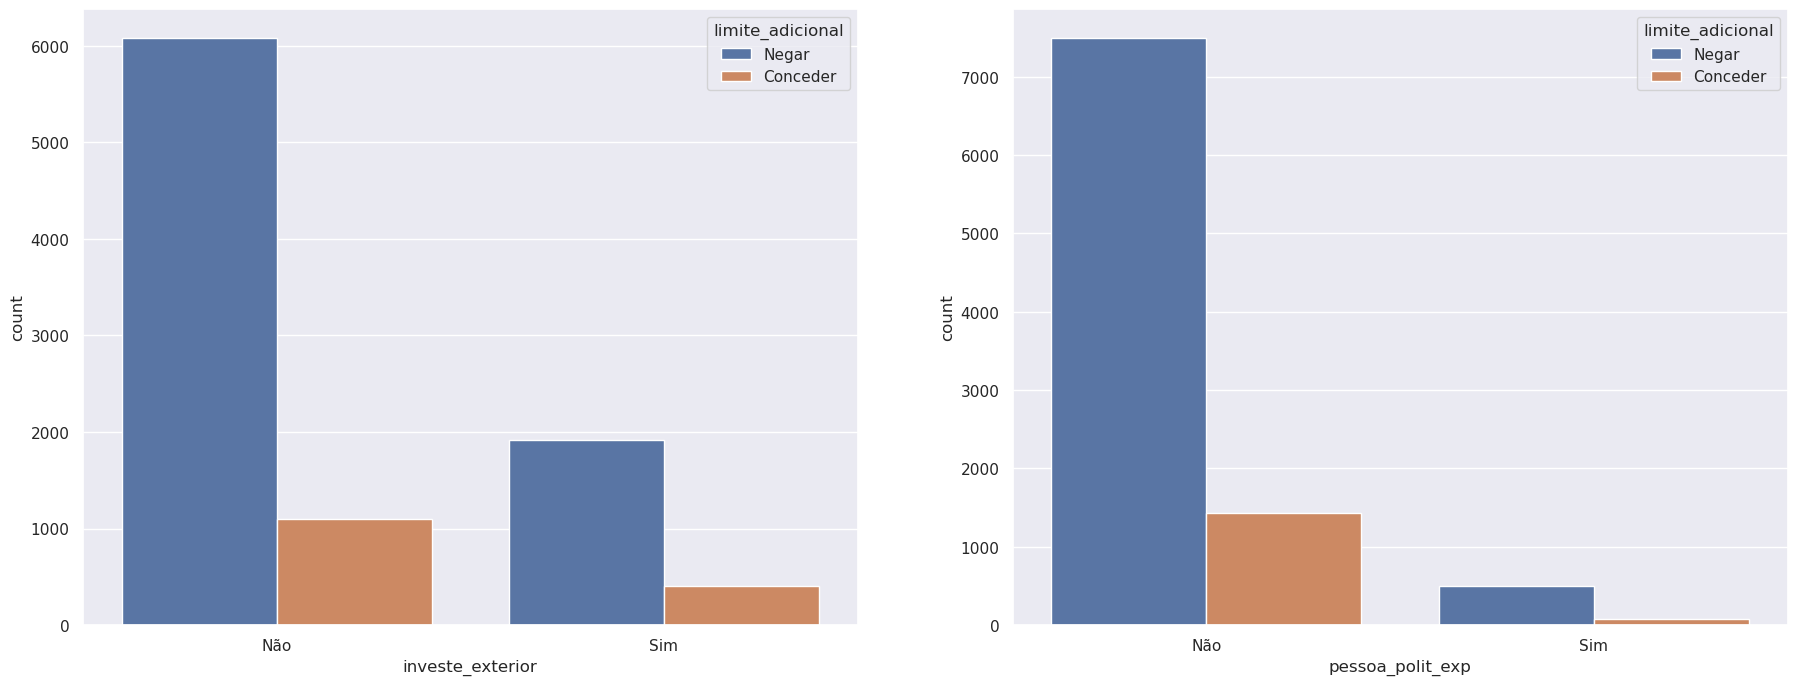

In [15]:
fig, ax  = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))

sns.countplot(x='investe_exterior', hue='limite_adicional', data=df1, ax=ax[0])
sns.countplot(x='pessoa_polit_exp', hue='limite_adicional', data=df1, ax=ax[1])

plt.show()

# 2.0. FEATURE ENGINEERING

In [16]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

In [17]:
#Image( 'img/MindMapHypothesis.png' )

## 2.2. Criacao das Hipoteses

### 2.2.1. Hipoteses *Agente 1*

### 2.2.2. Hipoteses *Agente 2*

### 2.2.3. Hipoteses *Agente 3*

## 2.3. Lista Final de Hipóteses

## 2.4. Feature Engineering

In [18]:
for col in df2.columns:
    print(f"{col}: {df2[col].nunique()}")

id_cliente: 9500
idade: 236
saldo_atual: 9408
divida_atual: 9330
renda_anual: 9492
valor_em_investimentos: 8623
taxa_utilizacao_credito: 9500
num_emprestimos: 58
num_contas_bancarias: 132
num_cartoes_credito: 205
dias_atraso_dt_venc: 73
num_pgtos_atrasados: 95
num_consultas_credito: 154
taxa_juros: 205
investe_exterior: 2
pessoa_polit_exp: 2
limite_adicional: 2


In [19]:
# map1 = {
#     'Não': 0,
#     'Sim': 1
# }

# df2['investe_exterior'] = df2['investe_exterior'].map(map1)

In [20]:
# map2 = {
#     'Não': 0,
#     'Sim': 1
# }

# df2['pessoa_polit_exp'] = df2['pessoa_polit_exp'].map(map2)

In [21]:
# map3 = {
#     'Negar': 0,
#     'Conceder': 1
# }

# df2['limite_adicional'] = df2['limite_adicional'].map(map3)

# 3.0. FILTRAGEM DE VARIÁVEIS

In [22]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas


## 3.2. Selecao das Colunas

In [23]:
# cols_drop = []
# df3 = df3.drop(columns=cols_drop)

# 4.0. ANALISE EXPLORATORIA DE DADOS

In [24]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

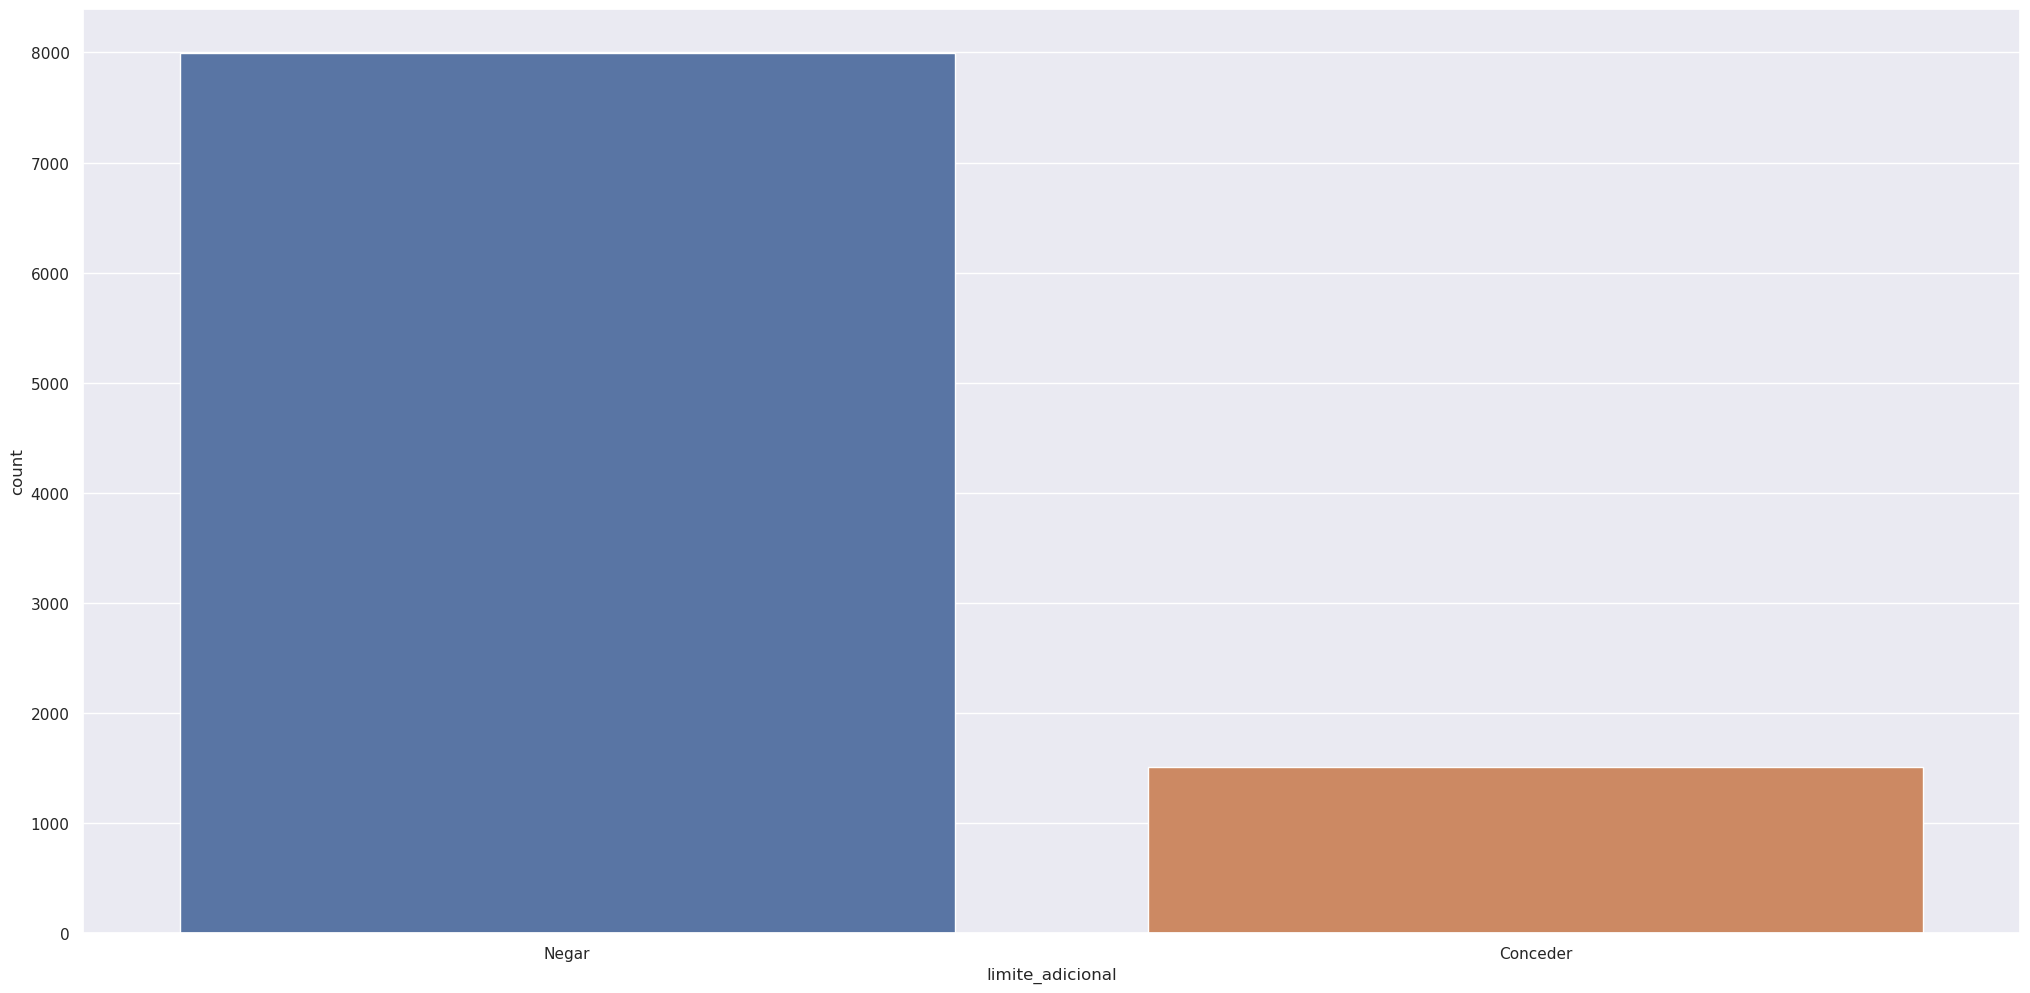

In [25]:
sns.countplot(x='limite_adicional', data=df4)

### 4.1.2. Numerical Variable

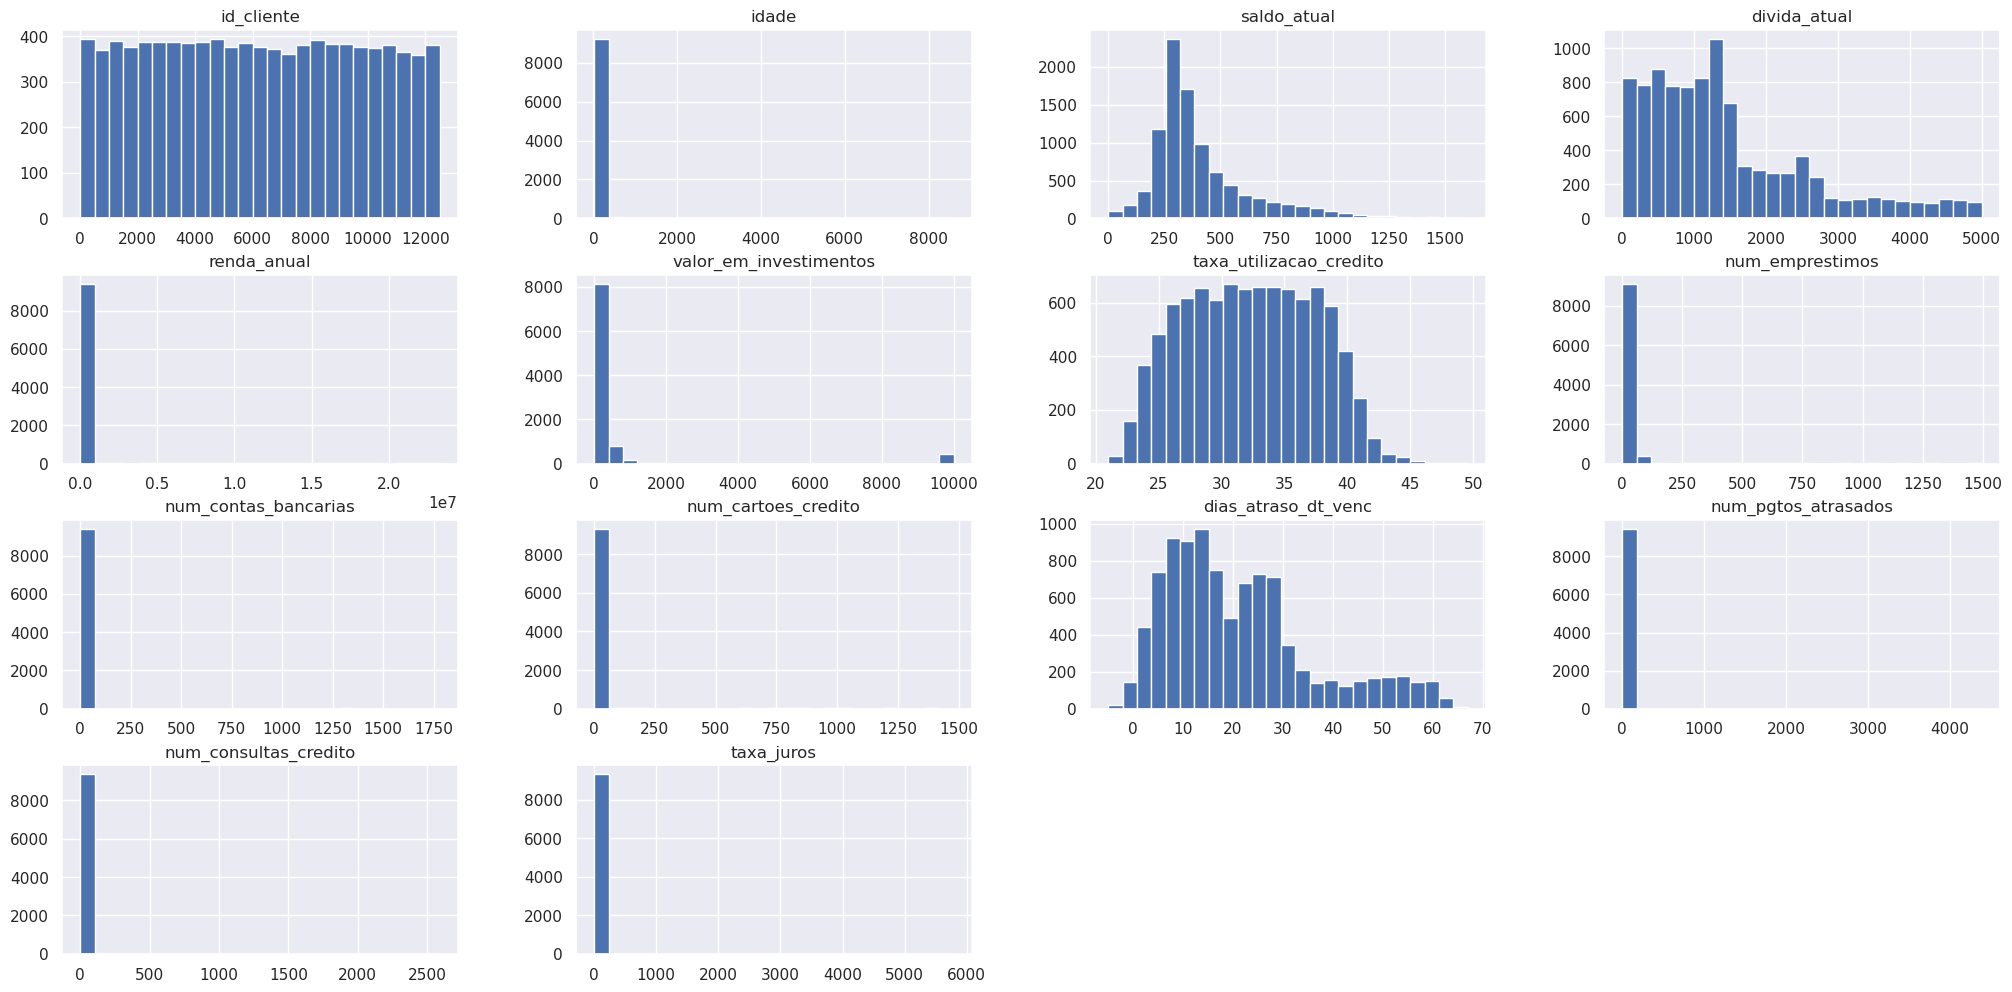

In [26]:
num_attributes.hist( bins=25 );

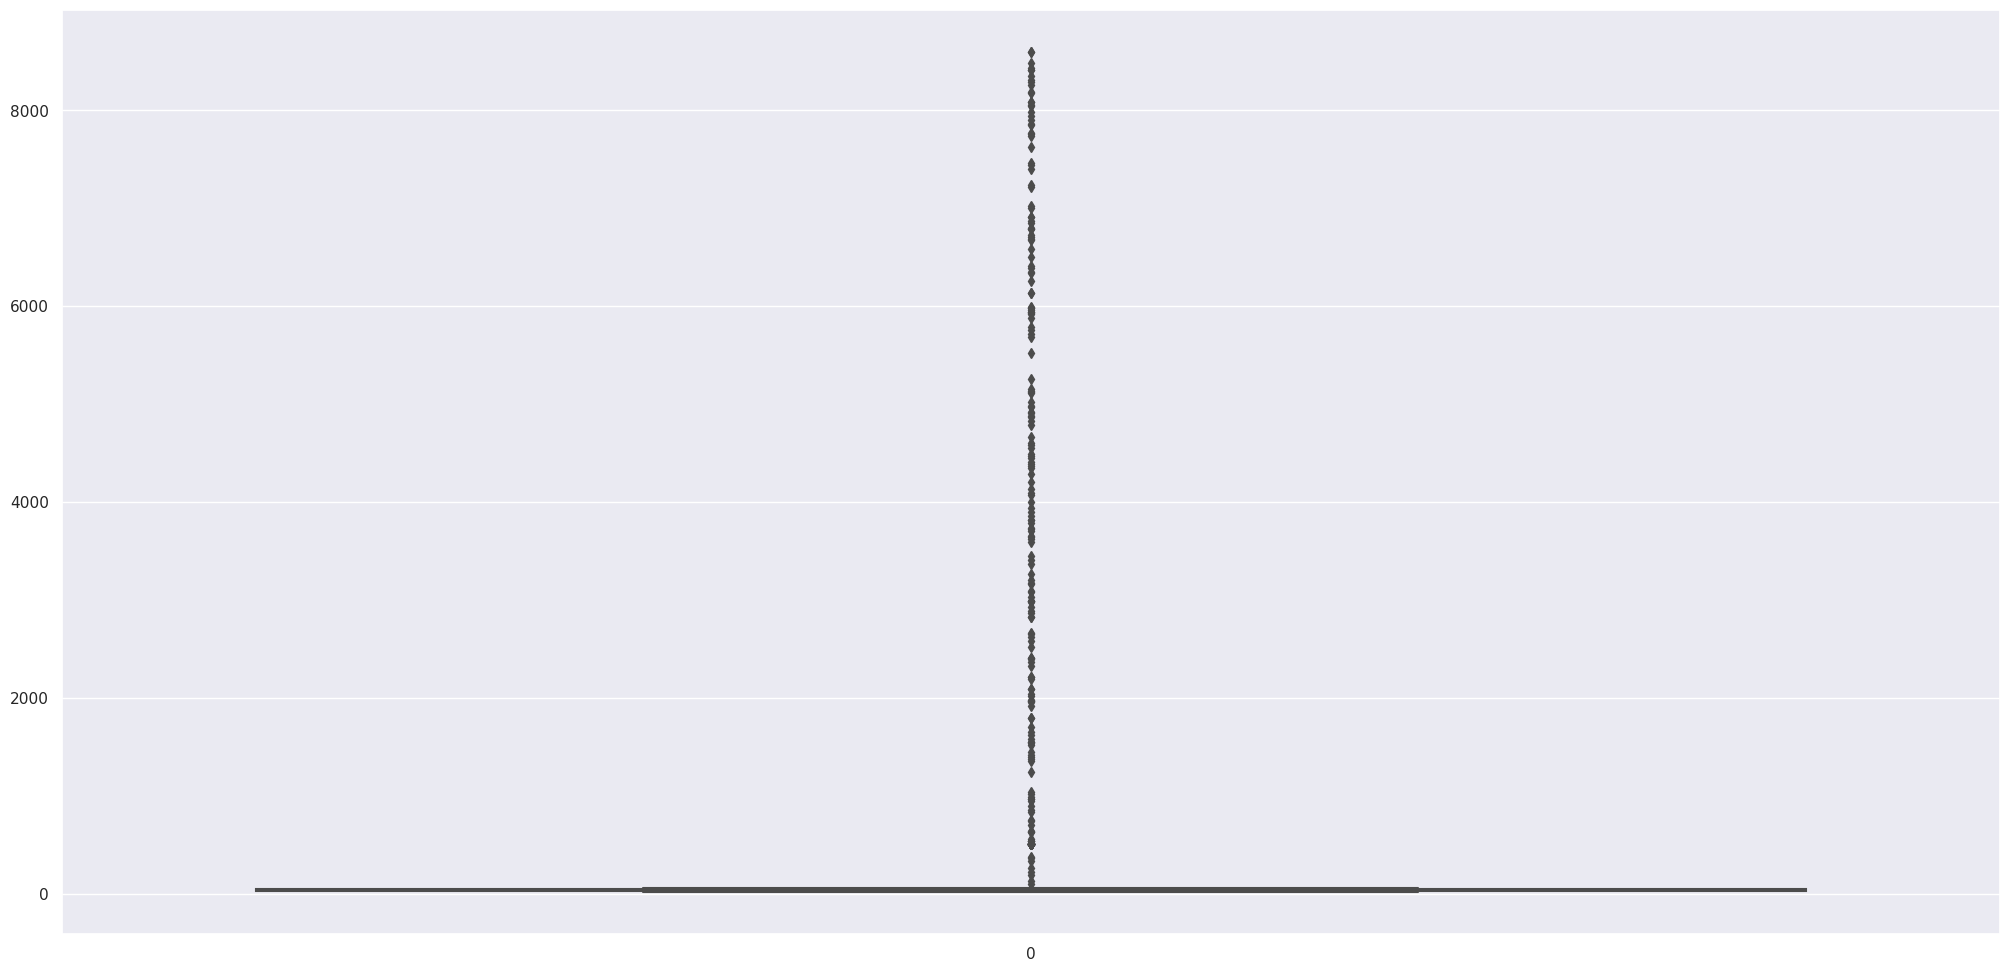

In [27]:
sns.boxplot(df4['idade'])


### 4.1.3. Categorical Variable

In [28]:
# # Printa countplot + kdeplot para cada variável categórica e seus níveis
# # cat1
# plt.subplot( 3, 2, 1 )
# a = df4[df4['cat1'] != 'nvl0']
# sns.countplot( a['cat1'] )

# plt.subplot( 3, 2, 2 )
# sns.kdeplot( df4[df4['cat1'] == 'nvl1']['target_variable'], label='nvl1', shade=True )
# sns.kdeplot( df4[df4['cat1'] == 'nvl2']['target_variable'], label='nvl1', shade=True )
# sns.kdeplot( df4[df4['cat1'] == 'nvl3']['target_variable'], label='nvl2', shade=True )

# # cat2
# plt.subplot( 3, 2, 3 )
# sns.countplot( df4['cat2'] )

# plt.subplot( 3, 2, 4 )
# sns.kdeplot( df4[df4['cat2'] == 'nvl1']['target_variable'], label='nvl1', shade=True )
# sns.kdeplot( df4[df4['cat2'] == 'nvl2']['target_variable'], label='nvl1', shade=True )
# sns.kdeplot( df4[df4['cat2'] == 'nvl3']['target_variable'], label='nvl2', shade=True )

# # cat3
# plt.subplot( 3, 2, 5 )
# sns.countplot( df4['cat3'] )

# plt.subplot( 3, 2, 6 )
# sns.kdeplot( df4[df4['cat3'] == 'nvl1']['target_variable'], label='nvl1', shade=True )
# sns.kdeplot( df4[df4['cat3'] == 'nvl2']['target_variable'], label='nvl1', shade=True )
# sns.kdeplot( df4[df4['cat3'] == 'nvl3']['target_variable'], label='nvl2', shade=True )

## 4.2. Analise Bivariada

## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

In [29]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])

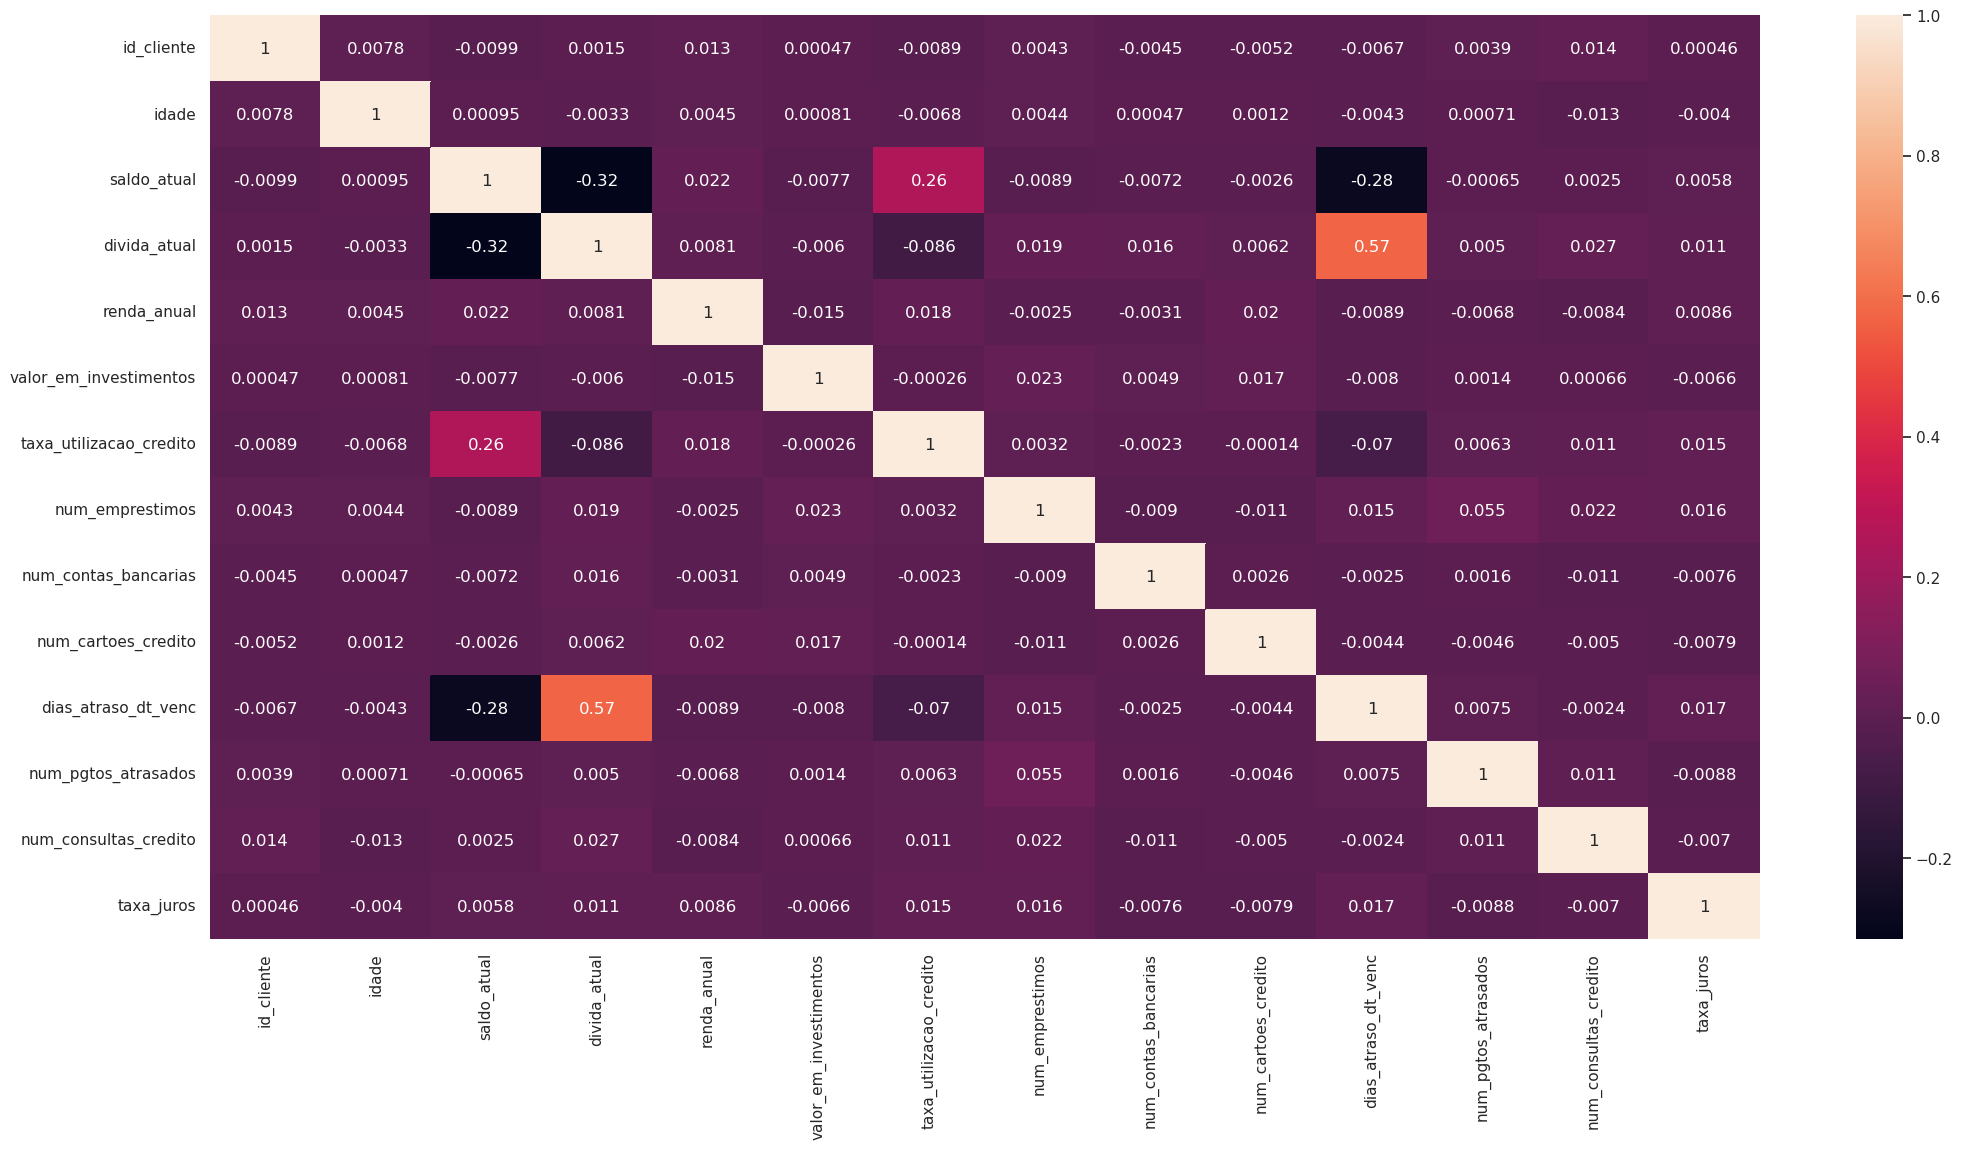

In [30]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

# 5.0. DATA PREPARATION

In [31]:
df5 = df4.copy()

## 5.1. Normalizacao

In [32]:
def norm_df(df):
    ss = StandardScaler()

    # saldo_autal
    df['saldo_atual'] = ss.fit_transform( df[['saldo_atual']].values )
    pickle.dump( ss, open( 'parameter/saldo_atual_scaler.pkl', 'wb') )

    # taxa_utilizacao_credito
    df['taxa_utilizacao_credito'] = ss.fit_transform( df[['taxa_utilizacao_credito']].values )
    pickle.dump( ss, open( 'parameter/taxa_utilizacao_credito_scaler.pkl', 'wb') )

    return df

In [33]:
df5 = norm_df(df5)

## 5.2. Rescaling

In [34]:
def rescale_df(df):
    rs = RobustScaler()
    mms = MinMaxScaler()

    ## Robust Scaler
    # idade
    df['idade'] = rs.fit_transform( df[['idade']].values )
    pickle.dump( rs, open( 'parameter/idade_scaler.pkl', 'wb') )

    # renda_anual
    df['renda_anual'] = rs.fit_transform( df[['renda_anual']].values )
    pickle.dump( rs, open( 'parameter/renda_anual_scaler.pkl', 'wb') )

    # valor_em_investimentos
    df['valor_em_investimentos'] = rs.fit_transform( df[['valor_em_investimentos']].values )
    pickle.dump( rs, open( 'parameter/valor_em_investimentos_scaler.pkl', 'wb') )

    # num_emprestimos
    df['num_emprestimos'] = rs.fit_transform( df[['num_emprestimos']].values )
    pickle.dump( rs, open( 'parameter/num_emprestimos_scaler.pkl', 'wb') )

    # num_contas_bancarias
    df['num_contas_bancarias'] = rs.fit_transform( df[['num_contas_bancarias']].values )
    pickle.dump( rs, open( 'parameter/num_contas_bancarias_scaler.pkl', 'wb') )

    # num_cartoes_credito
    df['num_cartoes_credito'] = rs.fit_transform( df[['num_cartoes_credito']].values )
    pickle.dump( rs, open( 'parameter/num_cartoes_credito_scaler.pkl', 'wb') )

    # num_pgtos_atrasados
    df['num_pgtos_atrasados'] = rs.fit_transform( df[['num_pgtos_atrasados']].values )
    pickle.dump( rs, open( 'parameter/num_pgtos_atrasados_scaler.pkl', 'wb') )

    # num_consultas_credito
    df['num_consultas_credito'] = rs.fit_transform( df[['num_consultas_credito']].values )
    pickle.dump( rs, open( 'parameter/num_consultas_credito_scaler.pkl', 'wb') )

    # taxa_juros
    df['taxa_juros'] = rs.fit_transform( df[['taxa_juros']].values )
    pickle.dump( rs, open( 'parameter/taxa_juros_scaler.pkl', 'wb') )

    ## MinMax Scaler
    # dias_atraso_dt_venc
    df['dias_atraso_dt_venc'] = mms.fit_transform( df[['dias_atraso_dt_venc']].values )
    pickle.dump( rs, open( 'parameter/dias_atraso_dt_venc_scaler.pkl', 'wb') )

    # divida_atual
    df['divida_atual'] = mms.fit_transform( df[['divida_atual']].values )
    pickle.dump( rs, open( 'parameter/divida_atual_scaler.pkl', 'wb') )

    return df

In [35]:
df5 = rescale_df(df5)

## 5.3. Transformacao

### 5.3.1. Encoding

### 5.3.2. Response Variable Transformation

### 5.3.3. Nature Transformation

# 6.0. FEATURE SELECTION

In [36]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [37]:
# Dividir dataset entre Treino (80%) e Teste (20%) 
X = df6.drop('limite_adicional', axis = 1).copy()
y = df6['limite_adicional'].copy()

x_train, x_test, y_train, y_test = ms.train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 42)

## 6.2. Boruta as Feature Selector

### 6.2.1. Best Features from Boruta

## 6.3. Manual Feature Selection

# 7.0. MACHINE LEARNING MODELLING

In [38]:
df7 = df6.copy()

In [39]:
# df2 será usado para splitar Treino e Validação
df7_2 = pd.concat([x_train, y_train], axis = 1)

# Dividir dataset entre Treino (90%) e Validação (10%)
X = df7_2.drop(['limite_adicional'], axis=1).copy()
y = df7_2['limite_adicional'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(X, y, stratify = y, test_size=0.10, random_state = 42)

In [40]:
# Dados de treino
print('x_train -> ',x_train.shape)
print('y_train -> ',y_train.shape)
# Dados de validação
print('x_val -> ',x_val.shape)
print('y_val -> ',y_val.shape)
# Dados de teste
print('x_test -> ',x_test.shape)
print('y_test -> ',y_test.shape)

x_train ->  (6840, 16)
y_train ->  (6840,)
x_val ->  (760, 16)
y_val ->  (760,)
x_test ->  (1900, 16)
y_test ->  (1900,)


### 7.0.1 Preparação dos Dados durante Cross Validation

Normalização

Rescaling

Encoding

In [41]:
dszfsdrt = 34

In [42]:
# Encodar features categóricas de treino
le_inv_ext = LabelEncoder()
le_pes_pol = LabelEncoder()
x_train['investe_exterior'] = le_inv_ext.fit_transform(x_train['investe_exterior'])
x_train['pessoa_polit_exp'] = le_pes_pol.fit_transform(x_train['pessoa_polit_exp'])

# Encodar var resposta de treino
lim_adi_dict = {'Negar':0, 'Conceder':1}
y_train = y_train.map(lim_adi_dict)

# Encodar features categóricas de validação
x_val['investe_exterior']   = le_inv_ext.transform(x_val['investe_exterior'])
x_val['pessoa_polit_exp']   = le_pes_pol.transform(x_val['pessoa_polit_exp'])

# Encodar var resposta de validação
y_val = y_val.map(lim_adi_dict)

## 7.1. Average Model

## 7.2. Linear Regression Model

In [43]:
# # model
# lr = LinearRegression().fit( x_train, y_train )

# # prediction
# yhat_lr = lr.predict( x_test )

# # performance
# lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
# lr_result

### 7.2.1. Linear Regression Model - Cross Validation

In [44]:
# lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
# lr_result_cv

## 7.3. Linear Regression Regularized Model - Lasso

In [45]:
# # model
# lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# # prediction
# yhat_lrr = lrr.predict( x_test )

# # performance
# lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
# lrr_result

### 7.3.1.  Lasso - Cross Validation

In [46]:
# lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
# lrr_result_cv

## 7.4. Random Forest Regressor

In [47]:
# # model
# rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# # prediction
# yhat_rf = rf.predict( x_test )

# # performance
# rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
# rf_result

### 7.4.1.  Random Forest Regressor - Cross Validation

In [48]:
# rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
# rf_result_cv

## 7.5. XGBoost Classifier

In [49]:
# Aplicação de modelos 
# Treinar XGBoost Classifier
# Model definition
model_xgboost = XGBClassifier(random_state=42)
# Model training
model_xgboost.fit(x_train, y_train)
# Model prediction
yhat_xgboost = model_xgboost.predict(x_val)

In [50]:
# Avaliação de modelos 
# Validar modelo com F1 Score (dados validação)
print(f"XGBoost - Média ponderada com F1 Score (dados validação): {round(f1_score(y_val, yhat_xgboost, average='weighted') ,3)}") #binary=default

XGBoost - Média ponderada com F1 Score (dados validação): 0.869


In [51]:
# Validar modelo com F1 Score, no método cross validation (dados validação) 
print(f"K-folds: {ms.cross_val_score(model_xgboost, x_val, y_val, scoring='f1', cv = 10)}") #'F1' métrica F1 Score p/ classificação binary
print(f"XGBoost - Média ponderada com F1 Score (dados validação): {round(ms.cross_val_score(model_xgboost, x_val, y_val, scoring='f1_weighted', cv = 10).mean() ,3)}")
# Performance manteve-se próxima com cross validation

K-folds: [0.63636364 0.44444444 0.33333333 0.54545455 0.6        0.33333333
 0.63636364 0.76190476 0.54545455 0.42105263]
XGBoost - Média ponderada com F1 Score (dados validação): 0.861


Treinamento de modelo com todos os dados

In [52]:
# Testar modelos
# Antes, juntar dados de treino + validação, formando um novo dataset de treino.
x_train_full = pd.concat([x_train, x_val])
y_train_full = pd.concat([y_train, y_val])

In [53]:
# Encodar features categóricas de teste
x_test['investe_exterior']   = le_inv_ext.transform(x_test['investe_exterior'])
x_test['pessoa_polit_exp']   = le_pes_pol.transform(x_test['pessoa_polit_exp'])

# Encodar var resposta de teste
y_test = y_test.map(lim_adi_dict)

In [54]:
# Treinar nova XGBoost, com o novo dataset treino
# Model definition
model_xgboost_full = XGBClassifier(random_state=42)
# Model training
model_xgboost_full.fit(x_train_full, y_train_full)
# Model prediction
# Passar os dados de teste separados anteriormente
yhat_xgboost_full = model_xgboost_full.predict(x_test)

In [55]:
# Validar modelo com F1 Score (dados teste)
print(f"XGBoost - Média ponderada com F1 Score (dados teste): {round(f1_score(y_test, yhat_xgboost_full, average='weighted') ,3)}") #binary=default

XGBoost - Média ponderada com F1 Score (dados teste): 0.865


### 7.5.1. XGBoost Claassifier - Cross Validation

In [56]:
# xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
# xgb_result_cv

## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [57]:
# modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
# modelling_result.sort_values( 'RMSE' )

### 7.6.2. Real Performance - Cross Validation

In [58]:
# modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
# modelling_result_cv

# 8.0. HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [59]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }
#
#MAX_EVAL = 5

In [60]:
#final_result = pd.DataFrame()
#
#for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
#    
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )
#
#    # performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#    final_result = pd.concat( [final_result, result] )
#        
#final_result

In [61]:
#final_result

## 8.2. Final Model

In [62]:
# param_tuned = {
#     'n_estimators': 3000,
#     'eta': 0.03,
#     'max_depth': 5,
#     'subsample': 0.7,
#     'colsample_bytree': 0.7,
#     'min_child_weight': 3 
#         }

In [63]:
# # model
# model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
#                                     n_estimators=param_tuned['n_estimators'], 
#                                     eta=param_tuned['eta'], 
#                                     max_depth=param_tuned['max_depth'], 
#                                     subsample=param_tuned['subsample'],
#                                     colsample_bytee=param_tuned['colsample_bytree'],
#                                     min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# # prediction
# yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# # performance
# xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
# xgb_result_tuned

In [64]:
# mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
# mpe

# 9.0. TRADUCAO E INTERPRETACAO DO ERRO

In [65]:
# df9 = X_test[ cols_selected_boruta_full ]

# # rescale
# df9['sales'] = np.expm1( df9['sales'] )
# df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [66]:
# # sum of predictions
# df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# # MAE and MAPE
# df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
# df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# # Merge
# df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
# df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# # Scenarios
# df92['worst_scenario'] = df92['predictions'] - df92['MAE']
# df92['best_scenario'] = df92['predictions'] + df92['MAE']

# # order columns
# df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [67]:
# df92.sort_values( 'MAPE', ascending=False ).head()

In [68]:
# sns.scatterplot( x='store', y='MAPE', data=df92 )

## 9.2. Total Performance

In [69]:
# df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
# df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
# df93

## 9.3. Machine Learning Performance

In [70]:
# df9['error'] = df9['sales'] - df9['predictions']
# df9['error_rate'] = df9['predictions'] / df9['sales']

In [71]:
# plt.subplot( 2, 2, 1 )
# sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
# sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

# plt.subplot( 2, 2, 2 )
# sns.lineplot( x='date', y='error_rate', data=df9 )
# plt.axhline( 1, linestyle='--')

# plt.subplot( 2, 2, 3 )
# sns.distplot( df9['error'] )

# plt.subplot( 2, 2, 4 )
# sns.scatterplot( df9['predictions'], df9['error'] )

# 10.0. Kaggle Submission

In [78]:
# Carregar dataset teste
df_ktest_raw = pd.read_csv('data/df_kaggle/test.csv')
x_ktest = df_ktest_raw.copy()
# Conferir dataset teste kaggle
x_ktest

In [79]:
# Encoding
# Encodar features categóricas de teste kaggle
df_test['investe_exterior'] = le_inv_ext.transform(df_test['investe_exterior'])
df_test['pessoa_polit_exp'] = le_pes_pol.transform(df_test['pessoa_polit_exp'])

In [80]:
# Fazer a previsão do score usando o modelo final treinado:
yhat_xgboost_ktest = model_xgboost_full.predict(df_test)

## 10.2 Dataframe de Submissão

In [81]:
# Preparação para submissão
# Criar dataset final
df_sub = pd.concat([df_test_raw['id_cliente'], pd.Series(yhat_xgboost_ktest, name='limite_adicional')], axis=1)

In [82]:
# Traduzir var resposta
lim_adi_dic_final = {0 : 'Negar', 1: 'Conceder'}
df_sub['limite_adicional'] = df_sub['limite_adicional'].map( lim_adi_dic_final )

In [83]:
# Visutalizar arquivo final para submissão ao Kaggle
df_sub[:5]

,id_cliente,limite_adicional
0,2,Negar
1,5,Negar
2,6,Negar
3,8,Negar
4,10,Negar


In [85]:
# Gerar export para submission no Kaggle
df_sub.to_csv('data/submissions/baseline_kaggle.csv', index=False) 